In [1]:
%load_ext autoreload
%autoreload

In [2]:
from utils_v1 import *


In [3]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import tracemalloc
import sys
import numpy as np
from src.dataset import (
    MultipleDates,
    PAMultipleDates,
    MTMultipleDates,
    MAMultipleDates,
    MSMultipleDates,
    PIMultipleDates,
    MOMultipleDates,
    L8MTMultipleDates,
    L8AMMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
from src.manager.multioutput import ManagerMCDropout, ManagerSingleRun, ManagerEnsemble, ManagerEvidential2, ManagerTTA
from src.Logger import Logger
import src.rasterTools as rasterTools



Tensorflow ver. 2.6.0


In [4]:
ic.configureOutput(includeContext=True)

In [5]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [6]:
config = {
	"training": False,
	"inferring": True,
	"site": "MT", # values: MT, PA, MS, PI, L8MT, L8AM
	"training_date": "current", # values: earlier, current
	"mode": "ensemble", # values: mcd, single_run, ensemble, evidential2, tta
	"uncertainty_method": "pred_var", # pred_var MI pred_entropy KL pred_entropy_single
	"loadInference": False,
	"removePolygons": True,
	"plotLandsat": False,
	"plotPOI": False,

	"save_probabilities": False,
	"addPastDeforestationInput": True,
	"classes_mode": False,																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																						
	"learning_rate": 1e-4,
    "use_cloud_mask": True,
    "mask_out_non_biome": False,
	# "mask_out_no_data": True


	"georreferenced_save": False,
	"drop_no_data_pixels": False,
	"use_entire_image_as_training": False

}

In [7]:
config['uncertainty_method']

'pred_var'

In [8]:



if config['mode'] == 'mcd':
	managerClass = ManagerMCDropout
	config['inference_times'] = 10
	config['training_times'] = 1
elif config['mode'] == 'single_run':
	managerClass = ManagerSingleRun
	config['inference_times'] = 1
	config['training_times'] = 1
	config['uncertainty_method'] = 'pred_entropy_single'
elif config['mode'] == 'ensemble':
	managerClass = ManagerEnsemble
	config['inference_times'] = 10
	config['training_times'] = 10
elif config['mode'] == 'evidential2':
	managerClass = ManagerEvidential2
	config['inference_times'] = 1
	config['training_times'] = 1
elif config['mode'] == 'tta':
	managerClass = ManagerTTA
	config['inference_times'] = 10
	config['training_times'] = 1
else:
	raise ValueError('Invalid mode')

print(config)

if config['site'] == 'PA':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2017, 2018]
	else:
		dates = [2018, 2019]
	datasetClass = PAMultipleDates
elif config['site'] == 'MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]
	datasetClass = MTMultipleDates
elif config['site'] == 'MS':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
		# dates = [2019, 2020]

	else:
		dates = [2019, 2020]
		# dates = [2020, 2021]

	datasetClass = MSMultipleDates
elif config['site'] == 'PI':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
		# dates = [2017, 2018]

	else:
		dates = [2019, 2020]
		# dates = [2018, 2019]

	datasetClass = PIMultipleDates
	config['mask_out_non_biome'] = True
elif config['site'] == 'MO':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]
	datasetClass = MOMultipleDates
elif config['site'] == 'L8MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2021, 2022]
	else:
		dates = [2022, 2023]
		# dates = [2021, 2022]
	datasetClass = L8MTMultipleDates
elif config['site'] == 'L8AM':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2021, 2022]
	else:
		dates = [2022, 2023]
	datasetClass = L8AMMultipleDates

else:
	raise ValueError('Invalid site')

dataset = datasetClass(config = config,
			   dates = dates, 
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	


if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

if managerClass == ManagerTTA:
	patchesHandler.test_time_augmentation = True


if config['training'] == False:

	if type(dataset) == PAMultipleDates:


		if config['training_date'] == 'current': exp = 0; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 1; repetition_id = 0
			# exp = 20; repetition_id = 0
			# exp = 50; repetition_id = 0

	elif type(dataset) == MTMultipleDates:
		
		if config['training_date'] == 'current': exp = 2; repetition_id = 8
		elif config['training_date'] == 'earlier': exp = 3; repetition_id = 6		

	elif type(dataset) == MSMultipleDates:

		if config['training_date'] == 'current': exp = 40; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			# exp = 5; repetition_id = 0		
			# exp = 24; repetition_id = 0	
			# exp = 30; repetition_id = 0	# L1C
			exp = 37; repetition_id = 0	# L1C (New)
			
	elif type(dataset) == PIMultipleDates:

		if config['training_date'] == 'current': 
			exp = 44; repetition_id = 4
			exp = 58; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 7; repetition_id = 0	
			## exp = 18; repetition_id = 0	
			exp = 27; repetition_id = 0 # L1C
			# exp = 28; repetition_id = 0 # L1C 2020
	elif type(dataset) == MOMultipleDates:

		if config['training_date'] == 'current': exp = 6; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 7; repetition_id = 0	
			exp = 19; repetition_id = 0	
	elif type(dataset) == L8MTMultipleDates:

		if config['training_date'] == 'current': exp = 38; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			
			exp = 38; repetition_id = 0	
	elif type(dataset) == L8AMMultipleDates:

		if config['training_date'] == 'current': exp = 38; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			
			exp = 39; repetition_id = 0	

else:

	exp = 61
	repetition_id = 0
	
logger = Logger()
manager = managerClass(config, dataset, patchesHandler, logger)
manager.defineExperiment(exp)


{'training': False, 'inferring': True, 'site': 'MT', 'training_date': 'current', 'mode': 'ensemble', 'uncertainty_method': 'pred_var', 'loadInference': False, 'removePolygons': True, 'plotLandsat': False, 'plotPOI': False, 'save_probabilities': False, 'addPastDeforestationInput': True, 'classes_mode': False, 'learning_rate': 0.0001, 'use_cloud_mask': True, 'mask_out_non_biome': False, 'georreferenced_save': False, 'drop_no_data_pixels': False, 'use_entire_image_as_training': False, 'inference_times': 10, 'training_times': 10}


ic| dataset.py:635 in __init__()- list(self.date_ids): [0]
ic| dataset.py:656 in __init__()
    self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| patchesHandler.py:189 in __init__()- self.input_image_shape: 21
ic| patchesHandler.py:190 in __init__()
    self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [9]:
patchesHandler

In [10]:
repetition_id

8

In [11]:
exp

2

In [12]:
dates

[2019, 2020]

In [13]:
manager.config

{'training': False,
 'inferring': True,
 'site': 'MT',
 'training_date': 'current',
 'mode': 'ensemble',
 'uncertainty_method': 'pred_var',
 'loadInference': False,
 'removePolygons': True,
 'plotLandsat': False,
 'plotPOI': False,
 'save_probabilities': False,
 'addPastDeforestationInput': True,
 'classes_mode': False,
 'learning_rate': 0.0001,
 'use_cloud_mask': True,
 'mask_out_non_biome': False,
 'georreferenced_save': False,
 'drop_no_data_pixels': False,
 'use_entire_image_as_training': False,
 'inference_times': 10,
 'training_times': 10,
 'dropout_training': False}

In [14]:
exp

2

In [15]:
manager

In [16]:
manager.setExperimentPath()
manager.createLogFolders()

In [17]:
# ic(type(dataset), exp, dataset.dates)


In [18]:

manager.loadLabel()

D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:733 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| dataset.py:736 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:740 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008_MT.tif


ic| dataset.py:744 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| dataset.py:746 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| dataset.py:725 in loadLabel()
    label_per_date.shape: (16795, 10420, 1)


Removing bufer................
Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]


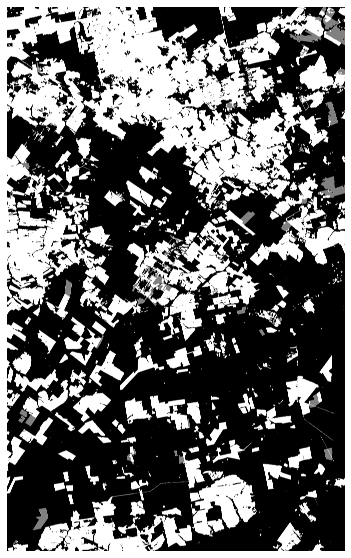

In [19]:
manager.logger.plotFigure(manager.label_mask, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [20]:

# Creating tile mask
manager.createTrainValTestTiles()


Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [21]:
def get_pixel_count_set(label, mask, set_id):
    label_set = label[mask == set_id]
    return np.unique(label_set, return_counts=True)


In [22]:

np.unique(manager.mask_tiles)
for set_id in np.unique(manager.mask_tiles):
    print('Set', set_id, get_pixel_count_set(manager.label_mask, manager.mask_tiles, set_id))


Set 1 (array([0, 1, 2], dtype=uint8), array([2828512,   22627, 4149017], dtype=int64))
Set 2 (array([0, 1, 2], dtype=uint8), array([1942472,    1350, 5056334], dtype=int64))
Set 3 (array([0, 1, 2], dtype=uint8), array([2524408,    2051, 4473697], dtype=int64))
Set 4 (array([0, 1, 2], dtype=uint8), array([3735363,   69783, 3195010], dtype=int64))
Set 5 (array([0, 1, 2], dtype=uint8), array([4025329,  633307, 2341520], dtype=int64))
Set 6 (array([0, 1, 2], dtype=uint8), array([4335661,   65975, 2598520], dtype=int64))
Set 7 (array([0, 1, 2], dtype=uint8), array([5369272,    2403, 1628481], dtype=int64))
Set 8 (array([0, 1, 2], dtype=uint8), array([4303573,    2724, 2693859], dtype=int64))
Set 9 (array([0, 1, 2], dtype=uint8), array([2643228,   95887, 4261041], dtype=int64))
Set 10 (array([0, 1, 2], dtype=uint8), array([4351078,  377878, 2271200], dtype=int64))
Set 11 (array([0, 1, 2], dtype=uint8), array([3057271,   78502, 3864383], dtype=int64))
Set 12 (array([0, 1, 2], dtype=uint8), ar

In [23]:

manager.label_mask.dtype

dtype('uint8')

In [24]:

manager.getLabelCurrentDeforestation()

In [25]:

manager.loadInputImage()

ic| dataset.py:676 in loadInputImage()
    image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)


In [26]:
if config['drop_no_data_pixels'] == True:
    manager.maskNoDataAsNotConsideredClass()

In [27]:
manager.dataset.previewBandsSnip

[[1, 2, 3], [11, 12, 13]]

In [28]:
condition = np.squeeze(np.zeros_like(manager.label_mask))


In [29]:
condition.shape

(16795, 10420)

In [30]:
manager.image_stack.shape

(16795, 10420, 21)

In [31]:
manager.dataset.previewBandsSnip[0]

[1, 2, 3]

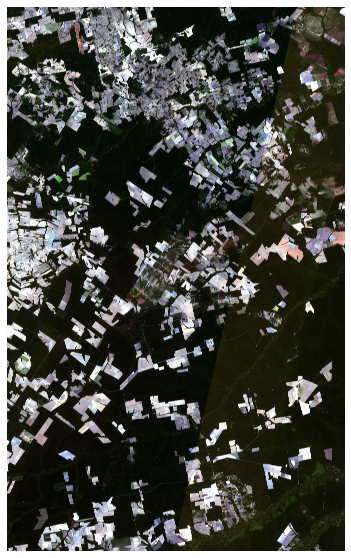

In [32]:
# plt.imshow(manager.image_stack[...,[3,2,1]])


plot_t0 = {"name": "t0", "bands": 1}


plot_tm1 = {"name": "tm1", "bands": 0}

plot_t = plot_t0
manager.logger.plotFigure(manager.image_stack[...,manager.dataset.previewBandsSnip[plot_t['bands']]], 
    name=f"{manager.dataset.site}_input_image_rgb_{plot_t['name']}", cmap=plt.cm.gray, savefig=True, figsize=(10,10))

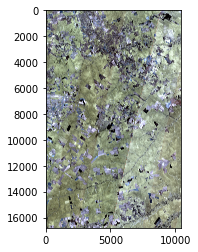

In [33]:
plt.imshow(manager.image_stack[...,[7,6,5]])

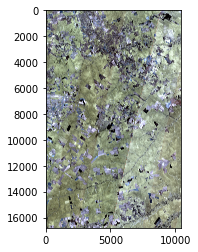

In [34]:
plt.imshow(manager.image_stack[...,[7,6,5]])

In [35]:

np.unique(manager.image_stack[...,0], return_counts=True)

(array([0.        , 0.07692308, 0.15384616, 0.23076925, 0.30769232,
        0.3846154 , 0.4615385 , 0.53846157, 0.61538464, 0.6923077 ,
        0.7692308 , 0.84615386, 0.923077  , 1.        ], dtype=float32),
 array([112618766,   2096062,   1054083,   1098901,   1007787,    876898,
           648966,    708581,    287191,    313901,    338545,    240796,
          1332783,  52380640], dtype=int64))

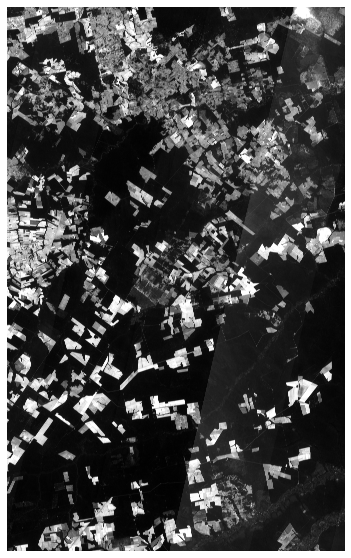

In [36]:

manager.logger.plotFigure(manager.image_stack[...,1], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

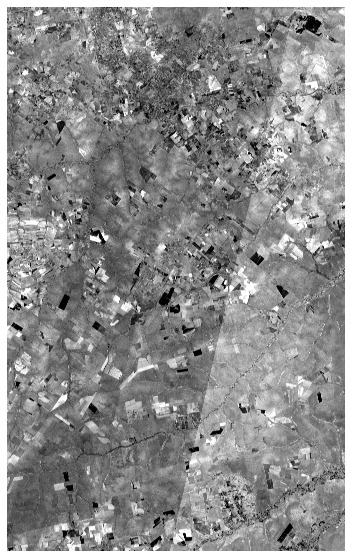

In [37]:

manager.logger.plotFigure(manager.image_stack[...,5], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

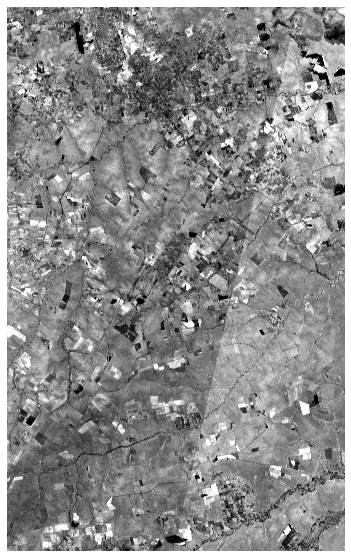

In [38]:

manager.logger.plotFigure(manager.image_stack[...,-3], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [39]:
def save_georreferenced(im, original_im_path, produced_im_path, bands = 1, plot = False):
    if len(im.shape) == 2:
        pad_values = ((0, 0), (0, 1))
    else:
        pad_values = ((0, 0), (0, 1), (0, 0))
    im_pad = np.pad(im, pad_values)
    print("im_pad.shape", im_pad.shape)

    if plot == True:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im_pad, cmap='jet')
        plt.axis('off')

    if len(im_pad.shape) == 2:
        im_pad = np.expand_dims(im_pad, axis=0)
    else:
        im_pad = np.transpose(im_pad, (2, 0, 1))
    print("im_pad.shape", im_pad.shape)

    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_pad.astype(np.float32), produced_im_path, bands = bands,
                    nodata=-1)
    del im_pad

In [40]:
import utils_v1
import rasterio

if config['georreferenced_save'] == True:
    # georref_im = utils_v1.load_tiff_image('D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif')
    original_im_path = os.path.join(manager.dataset.paths.optical_im_past_dates[dates[1]], 
        manager.dataset.paths.im_filenames[dates[1]][0])
    print("path",original_im_path)
    georref_im = utils_v1.load_tiff_image(original_im_path)

    print("georref_im.shape", georref_im.shape)

    del georref_im

In [41]:
if config['georreferenced_save'] == True:

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_sentinel2_{}_rgb_georreferenced.tif'.format(
        manager.dataset.site, dates[0])
    print(produced_im_path)
    bands = manager.dataset.previewBandsSnip[0]
    save_georreferenced(manager.image_stack[...,bands], original_im_path, produced_im_path, bands = 3)

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_sentinel2_{}_rgb_georreferenced.tif'.format(
        manager.dataset.site, dates[1])
    print(produced_im_path)
    bands = manager.dataset.previewBandsSnip[1]
    save_georreferenced(manager.image_stack[...,bands], original_im_path, produced_im_path, bands = 3)


In [42]:
np.unique(manager.label_mask, return_counts=True)

(array([0, 1, 2], dtype=uint8),
 array([109996296,   2271496,  62736108], dtype=int64))

In [43]:
# manager.maskNoDataAsNotConsideredClass()

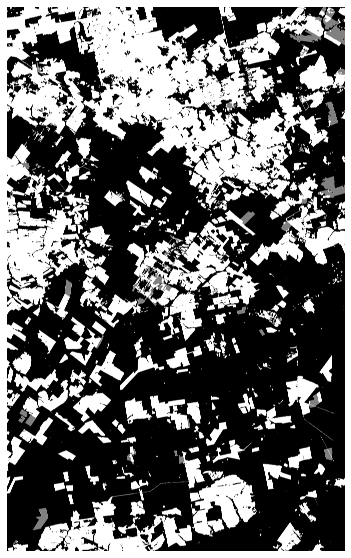

In [44]:

manager.logger.plotFigure(manager.label_mask, 
    name='label_mask', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [45]:

manager.getImageChannels()

ic| base.py:150 in getImageChannels()
    self.image_stack.shape: (16795, 10420, 21)
ic| base.py:152 in getImageChannels()- self.channels: 21


In [46]:

manager.getTrainValTestMasks()

Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [47]:
if config['use_entire_image_as_training'] == True:
    manager.mask_train_val[manager.mask_train_val == 0] = 1 # convert all test areas to train
    manager.mask_test[manager.mask_test == 1] = 0 # convert all test areas to train

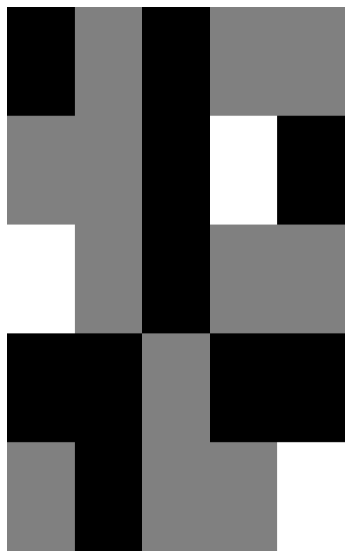

In [48]:
manager.logger.plotFigure(manager.mask_train_val, 
    name='Mask train val', cmap=plt.cm.gray, savefig=True, figsize=(10,10))


In [49]:

train_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 1)
val_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 2)
test_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 0)

total_unique = np.unique(manager.label_mask, return_counts=True)

In [50]:
print("train unique", train_unique)
print("val unique", val_unique)
print("test unique", test_unique)

print("total unique", total_unique)


train unique (array([0, 1, 2], dtype=uint8), array([54650365,  1153526, 28197981], dtype=int64))
val unique (array([0, 1, 2], dtype=uint8), array([11562693,   243728,  9194047], dtype=int64))
test unique (array([0, 1, 2], dtype=uint8), array([43783238,   874242, 25344080], dtype=int64))
total unique (array([0, 1, 2], dtype=uint8), array([109996296,   2271496,  62736108], dtype=int64))


In [51]:
print("train unique percentage", np.round(train_unique[1]/np.sum(train_unique[1]), 4))
print("val unique", np.round(val_unique[1]/np.sum(val_unique[1]), 4))
print("test unique", np.round(test_unique[1]/np.sum(test_unique[1]), 4))
print("total unique", np.round(total_unique[1]/np.sum(total_unique[1]) * 100, 1))


train unique percentage [0.6506 0.0137 0.3357]
val unique [0.5506 0.0116 0.4378]
test unique [0.6255 0.0125 0.3621]
total unique [62.9  1.3 35.8]


In [52]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    manager.createIdxImage()


In [53]:
if config["training"] == True:
    manager.extractCoords()

In [54]:
if config["training"] == True:
    manager.trainTestSplit()

In [55]:
if config["training"] == True:
    manager.label_mask.shape

In [56]:
if config["training"] == True:

    manager.logger.plotFigure(manager.label_mask[...,-1], 
        name='Reference', cmap=plt.cm.gray, savefig=False)



In [57]:
if config["training"] == True:
    np.unique(manager.label_mask)

In [58]:
if config["training"] == True:
    print(manager.coords_train)

In [59]:
if config["training"] == True:
    manager.retrieveSamplesOfInterest()

In [60]:
if config["training"] == True:
    inputSnipShow = True

In [61]:
# count, unique = np.unique(label_mask, return_counts=True)
# print(count, unique)
# print(unique[1]/unique[0])

In [62]:
'''
count, unique = np.unique(label_mask[mask_test == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_test == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [63]:
'''
count, unique = np.unique(label_mask[mask_train_val == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_train_val == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [64]:
manager.dataset.image_channels

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

In [65]:
manager.dataset.bands

10

In [66]:
manager.dataset.previewBandsSnip

[[1, 2, 3], [11, 12, 13]]

In [67]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 1000)


In [68]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 97)


In [69]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 300)

In [70]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [71]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [72]:
if config["training"] == True:
    manager.getGenerators()


In [73]:
if config["training"] == True:
    manager.fixChannelNumber()

In [74]:
if config["training"] == True:
    print(manager.path_exp)

In [75]:
if config["training"] == True:
    print(manager.channels)

In [76]:
if config["training"] == True:
    print(manager.image_stack.shape)

In [77]:
if config["training"] == True:
    print("config['training_times']", config["training_times"])

In [78]:
manager.class_n

3

In [79]:
measured_training_time = []
if config["training"] == True:
    for tm in range(config['training_times']):
        t = time.time()
        manager.repetition_id = tm
        manager.train()
        measured_training_time.append(time.time() - t)

In [80]:
print("measured_training_time", measured_training_time)
print("np.sum(np.array(measured_training_time))", np.sum(np.array(measured_training_time)))
print("np.mean(np.array(measured_training_time))", np.mean(np.array(measured_training_time)))

measured_training_time []
np.sum(np.array(measured_training_time)) 0.0
np.mean(np.array(measured_training_time)) nan


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [81]:
if config["training"] == True:
    manager.plotHistory()


In [82]:
if config["inferring"] != True:
    sys.exit()
else:
    manager.repetition_id = repetition_id

In [83]:
manager.image_stack.shape

(16795, 10420, 21)

In [84]:
manager.patchesHandler.dataset.image_channels[-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [85]:
if issubclass(type(dataset), MultipleDates):
	manager.channels = manager.patchesHandler.input_image_shape
	manager.image_stack = manager.image_stack[..., manager.patchesHandler.dataset.image_channels[-1]]
	manager.label_mask = manager.label_mask[...,-1]


In [86]:
manager.image_stack.shape

(16795, 10420, 21)

In [87]:
manager.setPadding()

-5.0 -12.0


In [88]:
import src.network as network
from tensorflow.keras.models import Model, load_model, Sequential
'''
def infer(self):

    self.h, self.w, self.c = self.image1_pad.shape
    self.c = self.channels
    patch_size_rows = self.h//self.n_rows
    patch_size_cols = self.w//self.n_cols
    num_patches_x = int(self.h/patch_size_rows)
    num_patches_y = int(self.w/patch_size_cols)

    ic(self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5')
    model = load_model(self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5', compile=False)
    
    if self.classes_mode == False:
        class_n = 3
        self.patchesHandler.class_n = class_n
    else:
        class_n = 2    
        self.patchesHandler.class_n = class_n + 1
    if self.config["loadInference"] == False:
        if self.config["save_probabilities"] == False:
            if self.classes_mode == False:
                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], self.config["inference_times"]), dtype = np.float32)
            else:
                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], class_n, self.config["inference_times"]), dtype = np.float32)

            # self.prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, self.config["inference_times"]), dtype = np.float32)
        print("Dropout training mode: {}".format(self.config['dropout_training']))
        new_model = network.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, self.c), 
            nb_filters = self.nb_filters, n_classes = class_n, dropout_seed = None, training=self.config['dropout_training'])

        for l in range(1, len(model.layers)):
            new_model.layers[l].set_weights(model.layers[l].get_weights())
        
        

        metrics_all =[]
        with tf.device('/cpu:0'):
            for tm in range(0,self.config["inference_times"]):

                print('time: ', tm)

                
                # Recinstructing predicted map
                start_test = time.time()
                
                prob_reconstructed = self.patchesHandler.infer(
                        new_model, self.image1_pad, self.h, self.w, 
                        num_patches_x, num_patches_y, patch_size_rows, 
                        patch_size_cols, classes_mode = self.classes_mode)
                        
                ts_time =  time.time() - start_test

                if self.config["save_probabilities"] == True:
                    np.save(self.path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
                else:
                    self.prob_rec[...,tm] = prob_reconstructed
                
                metrics_all.append(ts_time)
                del prob_reconstructed
            metrics_ = np.asarray(metrics_all)
            # Saving test time
            np.save(self.path_exp+'/metrics_ts.npy', metrics_)
    del self.image1_pad
'''

'\ndef infer(self):\n\n    self.h, self.w, self.c = self.image1_pad.shape\n    self.c = self.channels\n    patch_size_rows = self.h//self.n_rows\n    patch_size_cols = self.w//self.n_cols\n    num_patches_x = int(self.h/patch_size_rows)\n    num_patches_y = int(self.w/patch_size_cols)\n\n    ic(self.path_models+ \'/\' + self.method +\'_\'+str(self.repetition_id)+\'.h5\')\n    model = load_model(self.path_models+ \'/\' + self.method +\'_\'+str(self.repetition_id)+\'.h5\', compile=False)\n    \n    if self.classes_mode == False:\n        class_n = 3\n        self.patchesHandler.class_n = class_n\n    else:\n        class_n = 2    \n        self.patchesHandler.class_n = class_n + 1\n    if self.config["loadInference"] == False:\n        if self.config["save_probabilities"] == False:\n            if self.classes_mode == False:\n                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], self.config["inference_times"]), dtype = np.float32)\n            else:

In [89]:
'''
import types

manager.infer = types.MethodType(infer, manager)
'''


'\nimport types\n\nmanager.infer = types.MethodType(infer, manager)\n'

In [90]:
repetition_id

8

In [91]:
manager.infer()

time:  0
Loading model in: D:/Jorge/datasets/deforestation/experiments/MT/exp2/models/resunet_0.h5
runtime_repetition 60.16
time:  1
Loading model in: D:/Jorge/datasets/deforestation/experiments/MT/exp2/models/resunet_1.h5
runtime_repetition 61.54
time:  2
Loading model in: D:/Jorge/datasets/deforestation/experiments/MT/exp2/models/resunet_2.h5
runtime_repetition 63.0
time:  3
Loading model in: D:/Jorge/datasets/deforestation/experiments/MT/exp2/models/resunet_3.h5
runtime_repetition 62.22
time:  4
Loading model in: D:/Jorge/datasets/deforestation/experiments/MT/exp2/models/resunet_4.h5
runtime_repetition 65.79
time:  5
Loading model in: D:/Jorge/datasets/deforestation/experiments/MT/exp2/models/resunet_5.h5
runtime_repetition 64.76
time:  6
Loading model in: D:/Jorge/datasets/deforestation/experiments/MT/exp2/models/resunet_6.h5
runtime_repetition 65.68
time:  7
Loading model in: D:/Jorge/datasets/deforestation/experiments/MT/exp2/models/resunet_7.h5
runtime_repetition 65.42
time:  8


In [92]:
manager.loadPredictedProbabilities()

In [93]:
manager.prob_rec.shape

(16800, 10432, 10)

In [94]:
'''
if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
'''

'\nif useLessInferenceRuns == True:\n    ic(reducedInferenceRuns)\n\n    prob_rec_all = prob_rec.copy()\n    prob_rec = prob_rec_all[:reducedInferenceRuns]\n    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))\n'

In [95]:
manager.prob_rec.shape

(16800, 10432, 10)

In [96]:
manager.getMeanProb()

In [97]:
manager.logger.getStats(manager.mean_prob)

ic| Logger.py:123 in getStats()
    np.min(value): 2.9159002e-20
    np.mean(value): 0.015122748
    np.max(value): 1.0


In [98]:
ic(manager.mean_prob.shape)

ic| 3703776524.py:1 in <cell line: 1>()
    manager.mean_prob.shape: (16800, 10432)


(16800, 10432)

In [99]:
manager.unpadMeanProb()

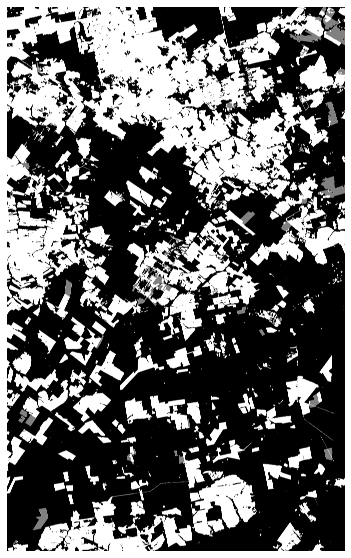

In [100]:
manager.logger.plotFigure(manager.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [101]:
manager.squeezeLabel()

In [102]:
manager.setMeanProbNotConsideredAreas()
# manager.logger.plotFigure(manager.mean_prob, 
#             name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [103]:
print(manager.label_mask.shape)

(16795, 10420)


In [104]:
# manager.getLabelTest()

In [105]:
# manager.getMAP()

In [106]:
manager.prob_rec.shape

(16800, 10432, 10)

In [107]:
manager.preprocessProbRec()
print(manager.prob_rec.shape)

(10, 16800, 10432, 1)


In [108]:
manager.prob_rec.shape

(10, 16800, 10432, 1)

In [109]:
manager.logger.getStats(manager.prob_rec)

ic| Logger.py:123 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.0151181035
    np.max(value): 1.0


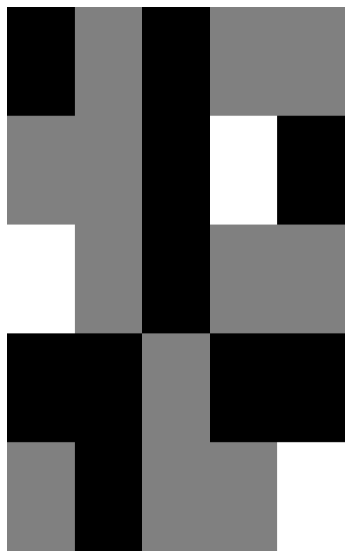

In [110]:
manager.logger.plotFigure(manager.mask_train_val, 
            name=manager.dataset.site + manager.title_name + ' Train val mask.png', figsize=(10,10), savefig=True)

In [111]:
manager.getLabelCurrentDeforestation()

In [112]:
manager.applyProbabilityThreshold()

(16795, 10420)
(array([0., 1.], dtype=float32), array([172681153,   2322747], dtype=int64))


ic| base.py:468 in applyProbabilityThreshold()
    self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)


In [113]:
manager.getTestValues()

ic| base.py:491 in getTestValues()- predicted_test.shape: (70001560,)
ic| base.py:500 in getTestValues()- predicted_test.shape: (44657480,)


In [114]:
manager.removeSmallPolygons()

ic| metrics.py:213 in removeSmallPolygonsForMetrics()
    np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172681153,   2322747], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172776032,   2227868], dtype=int64))
ic| metrics.py:215 in removeSmallPolygonsForMetrics()
    np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174909021,     94879], dtype=int64))


In [115]:
manager.calculateMetrics()

ic| base.py:544 in calculateMetrics()
    self.f1: 81.37
    self.precision: 81.59
    self.recall: 81.16


In [116]:
manager.getValidationValuesForMetrics()
manager.calculateMetricsValidation()

ic| base.py:473 in getValidationValuesForMetrics()
    self.label_mask_val.shape: (21000468,)
ic| base.py:479 in getValidationValuesForMetrics()
    self.label_mask_val_valid.shape: (11795630,)
ic| base.py:555 in calculateMetricsValidation()
    f1_val: 97.72
    precision_val: 98.05
    recall_val: 97.39
    mAP_val: 99.49


In [117]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    manager.calculateMAPWithoutSmallPolygons()

In [118]:
manager.get_label_no_buffer()

D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:733 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| dataset.py:736 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:740 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008_MT.tif


ic| dataset.py:744 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| dataset.py:746 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| dataset.py:725 in loadLabel()
    label_per_date.shape: (16795, 10420, 1)


In [119]:
manager.getErrorMask()

(array([0., 1.], dtype=float32), array([174491508,    512392], dtype=int64))


In [120]:
manager.getErrorMaskToShowRGB()

[0. 1.]


In [121]:

def plotFigure(figure, name='output/figure', cmap = plt.cm.gray, 
                savefig=False, figsize=(10,10), dpi=200, axis_off = True):
    plt.figure(figsize=figsize)
    plt.imshow(figure, cmap=cmap)

    # title_name = 'ResUnet'
    if axis_off == True:
        plt.axis('off')
    if savefig == True:
        plt.savefig('output/figures/' + name, dpi=dpi, bbox_inches='tight')


In [122]:
'''
import types

manager.setUncertainty = types.MethodType(setUncertainty, manager)
'''


'\nimport types\n\nmanager.setUncertainty = types.MethodType(setUncertainty, manager)\n'

In [123]:
manager.config['uncertainty_method']

'pred_var'

In [124]:
manager.config['site']

'MT'

In [125]:
manager.config['uncertainty_method'] = "pred_var"


In [126]:
print(np.min(manager.prob_rec), np.mean(manager.prob_rec), np.max(manager.prob_rec))
print(np.std(manager.prob_rec))
print(manager.prob_rec.shape)

0.0 0.0151181035 1.0
0.11100089
(10, 16800, 10432, 1)


In [127]:
manager.setUncertainty()

In [128]:
print(np.min(manager.uncertainty_map), np.mean(manager.uncertainty_map), np.max(manager.uncertainty_map))

0.0 0.000811021 0.23400486


In [129]:
# manager.uncertainty_map[manager.uncertainty_map>1] = 1

In [130]:
manager.logger.getStats(manager.uncertainty_map)

ic| Logger.py:123 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.000811021
    np.max(value): 0.23400486


In [131]:
manager.getUncertaintyToShow()
manager.logger.getStats(manager.uncertainty_to_show)


ic| Logger.py:123 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.0007103367
    np.max(value): 0.23400486


ic| 3983861654.py:8 in <cell line: 8>()
    manager.uncertainty_to_show.shape: (16795, 10420)


fig_name MTResUnet uncertainty pred_var.png


(16795, 10420)

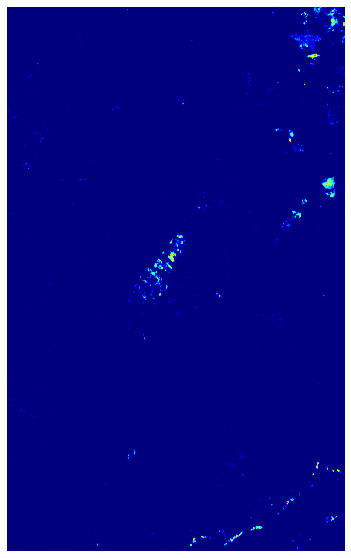

In [132]:
fig_name = manager.dataset.site + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png'
# manager.logger.
plotFigure(manager.uncertainty_to_show, 
            name=fig_name, 
            figsize=(10,10), cmap='jet', savefig=True,
            dpi=500)
print("fig_name", fig_name)
ic(manager.uncertainty_to_show.shape)



In [133]:
'''
import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(manager.uncertainty_map, ax, title = 'Uncertainty predictive entropy')

plt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')
'''

"\nimport src.uncertainty\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nsrc.uncertainty.show_im(manager.uncertainty_map, ax, title = 'Uncertainty predictive entropy')\n\nplt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', \n    dpi=150, bbox_inches='tight')\n"

fig_name output/figures/MTResUnet uncertainty pred_var_bar.png


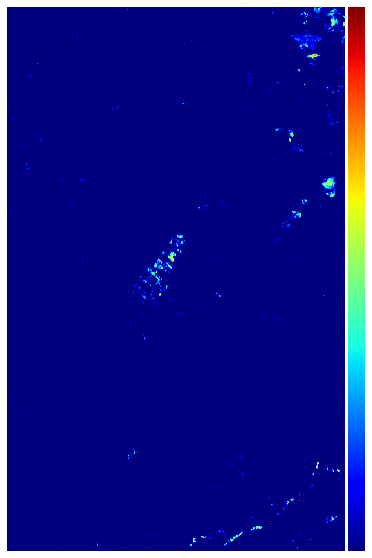

In [134]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    # plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 
    ax.set_axis_off()
    plt.xticks(visible=False)
    plt.yticks(visible=False)

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
# src.uncertainty.show_im(manager.uncertainty_to_show, ax, title = 'Uncertainty predictive entropy')
show_im(manager.uncertainty_to_show, ax, title = 'Uncertainty predictive entropy')


fig_name = 'output/figures/' + manager.dataset.site + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'_bar.png'
plt.axis('off')
plt.savefig(fig_name, 
    dpi=500, bbox_inches='tight')
print("fig_name", fig_name)

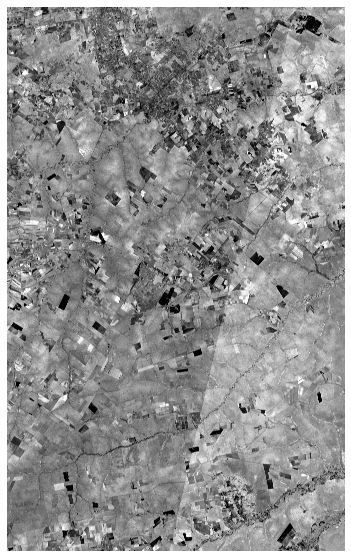

In [135]:

manager.logger.plotFigure(manager.image_stack[...,7], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [136]:
np.unique(manager.mask_train_val, return_counts=True)

(array([0, 1, 2], dtype=uint8),
 array([70001560, 84001872, 21000468], dtype=int64))

In [137]:
manager.error_mask.shape

(16795, 10420)

In [138]:
manager.npad

((0, 5), (0, 12), (0, 0))

In [139]:
manager.getValidationValues2()
manager.getTestValues2()

ic| base.py:595 in getTestValues2()
    self.label_mask.shape: (16795, 10420)
ic| base.py:596 in getTestValues2()
    self.mask_test.shape: (16795, 10420)
ic| base.py:600 in getTestValues2()
    self.label_mask_test.shape: (70001560,)
ic| base.py:608 in getTestValues2()
    self.error_mask_test.shape: (44623406,)


In [140]:
# config["plotLandsat"] = True

In [141]:
# manager.logger.plotCropSample(manager)

In [142]:
# if config["plotLandsat"] == True:
label_tmp_dates = []
for date in dataset.prodes_dates:
    label_tmp_date = dataset.loadLabelFromDate(date)
    label_tmp_date = label_tmp_date[:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1]]
    label_tmp_dates.append(label_tmp_date)

D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:733 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| dataset.py:736 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:740 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008_MT.tif


ic| dataset.py:744 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| dataset.py:746 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:733 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| dataset.py:736 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:740 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008_MT.tif


ic| dataset.py:744 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| dataset.py:746 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:733 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2021) = 1


ic| dataset.py:736 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:740 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008_MT.tif


ic| dataset.py:744 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| dataset.py:746 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


In [143]:
config["plotLandsat"] = True

In [144]:
if config["plotLandsat"] == True:
    # del manager.image_stack
    import src.lansdatLoader as ll
    import importlib
    importlib.reload(ll)
    landsatLoader = ll.LandsatLoader(dataset,
                                    manager.mask_tiles.shape)
    # landsatLoader = ll.LandsatLoaderHistogramMatching(dataset, 
    #                                                   manager.mask_tiles.shape)

    
    ims = landsatLoader.load()


Loading D:/Jorge/datasets/landsat/MT/landsat_MT_2019.tif
D:/Jorge/datasets/landsat/MT/landsat_MT_2019.tif
np.nanmin(im), np.nanmean(im), np.nanmax(im) 0 62.75064505227991 255
Loading D:/Jorge/datasets/landsat/MT/landsat_MT_2020.tif
D:/Jorge/datasets/landsat/MT/landsat_MT_2020.tif
np.nanmin(im), np.nanmean(im), np.nanmax(im) 0 71.29106810754617 255
Loading D:/Jorge/datasets/landsat/MT/landsat_MT_2021.tif
D:/Jorge/datasets/landsat/MT/landsat_MT_2021.tif
np.nanmin(im), np.nanmean(im), np.nanmax(im) 0 112.13710491533134 255


In [145]:
if config["plotLandsat"] == True:
    for idx in range(len(ims)):
        ims[idx] = ims[idx][:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1],:]
        print(ims[idx].shape)
    print("ims.shape", ims[0].shape)
    print("manager.label_no_buffer.shape", manager.label_no_buffer.shape)
    ims = landsatLoader.darken_past_deforestation(ims, manager.label_no_buffer)
    ims = landsatLoader.add_deforestation_edges_by_date(ims, label_tmp_dates[:])

(16795, 10420, 3)
(16795, 10420, 3)
(16795, 10420, 3)
ims.shape (16795, 10420, 3)
manager.label_no_buffer.shape (16795, 10420)


In [146]:
# ims[0].shape

In [147]:
# plt.figure(figsize=(10,10))
# plt.imshow(ims[0])

In [148]:

import src.Logger as lg
importlib.reload(lg)
logger = lg.Logger()
manager.logger = logger


In [149]:
if config["plotLandsat"] == False:
    import src.lansdatLoader as ll
    import importlib
    importlib.reload(ll)    
    landsatLoader = ll.LandsatLoader(dataset,
                                    manager.mask_tiles.shape)
    image_2021 = np.load(os.path.join(manager.dataset.paths.optical_im_past_dates[2020], 'optical_im.npy')).astype('float32')# [manager.dataset.lims[0]:manager.dataset.lims[1], manager.dataset.lims[2]:manager.dataset.lims[3]]

    ims = [manager.image_stack[...,manager.dataset.previewBandsSnip[0]],
           manager.image_stack[...,manager.dataset.previewBandsSnip[1]],
           image_2021[...,[0,1,2]]]
    for idx in range(len(ims)):
        ims[idx] = ims[idx][:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1],:]
        print(ims[idx].shape)    
    ims = landsatLoader.darken_past_deforestation(ims, manager.label_no_buffer)
    ims = landsatLoader.add_deforestation_edges_by_date(ims, label_tmp_dates[:])


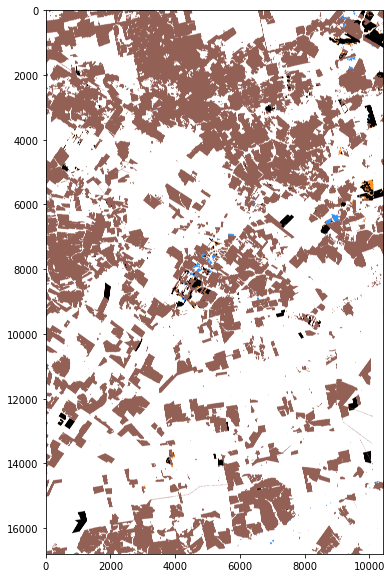

In [150]:

# manager.logger.
plotFigure(manager.error_mask_to_show_rgb[...,::-1], 
            name=manager.dataset.site + manager.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=500, axis_off=False) # dpi=300

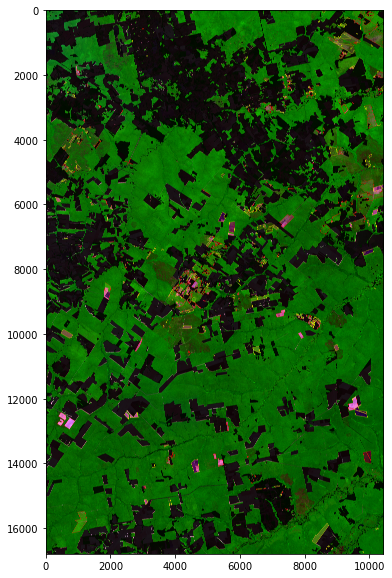

In [151]:
plotFigure(ims[2], 
            name=manager.dataset.site + manager.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=500, axis_off=False) # dpi=300

In [152]:
manager.dataset.previewLims1 = np.array([2200, 3200, 6900, 7900])
manager.dataset.previewLims2 = np.array([500, 1500, 3500, 4500])

ic| Logger.py:213 in plotCropSampleLandsat()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| Logger.py:213 in plotCropSampleLandsat()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)


manager.dataset.previewLims 0: [11500 12500  9000 10000]
manager.dataset.previewLims 1: [ 5000  6000  9500 10500]
[(16795, 10420, 3), (16795, 10420, 3), (16795, 10420, 3), (16795, 10420), (16795, 10420, 3), (16795, 10420)]
Saving point of interest number 0. Lims: [11500 12500  9000 10000]
(1000, 1000, 3)
Saving point of interest number 1. Lims: [ 5000  6000  9500 10500]
(1000, 920, 3)
(1000, 1000, 3)


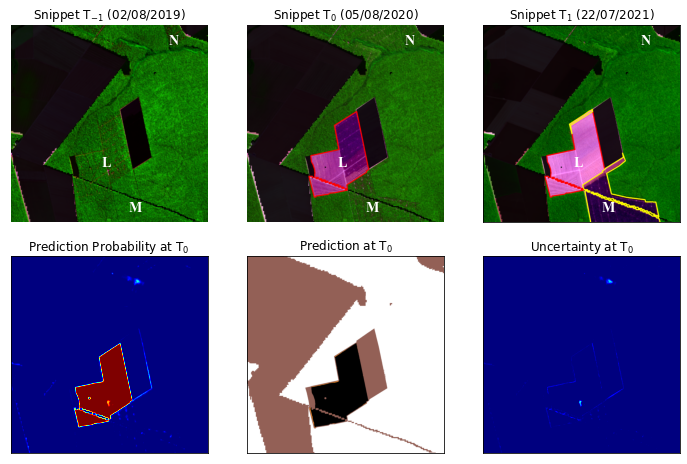

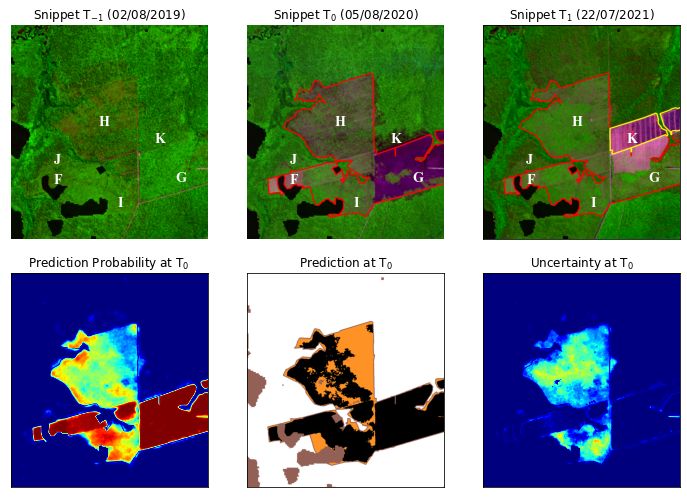

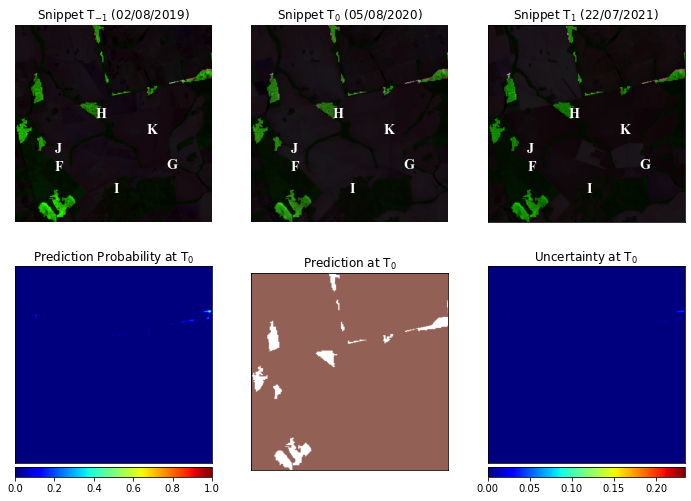

In [153]:
# manager.dataset.previewLims0 = np.array([2600, 3300, 13450, 14150])
# manager.dataset.previewLims1 = np.array([1300, 2000, 11000, 11700])
# manager.dataset.previewLims2 = np.array([6300, 7300, 12200, 13200])    

# manager.dataset.previewLims3 = np.array([4300, 5300, 2600, 3600])  
# manager.dataset.previewLims4 = np.array([18355, 19355, 10600, 11600]) 
# manager.dataset.previewLims5 = np.array([6000, 6500, 14800, 15300])   




'''
manager.dataset.previewLims0 = np.array([3850, 4150, 11800, 12100])
manager.dataset.previewLims1 = np.array([3500, 4500, 14000, 15000])
manager.dataset.previewLims2 = np.array([13600, 13900, 4450, 4750])
manager.dataset.previewLims3 = np.array([17770, 18070, 14600, 14900])
manager.dataset.previewLims4 = np.array([ 6000,  7000, 15600, 16600])
'''
if config["plotLandsat"] == True:
 
    logger.plotCropSampleLandsat(manager, ims, show_polygon_text = False)

else:
    '''
    # MS
    manager.dataset.previewLims0 = np.array([3850, 4150, 11800, 12100])
    manager.dataset.previewLims1 = np.array([3500, 4500, 14000, 15000])
    manager.dataset.previewLims2 = np.array([13600, 13900, 4450, 4750])
    manager.dataset.previewLims3 = np.array([17770, 18070, 14600, 14900])

    # PI

    manager.dataset.previewLims0 = np.array([2600, 3300, 13450, 14150])
    manager.dataset.previewLims1 = np.array([1300, 2000, 11000, 11700])
    manager.dataset.previewLims2 = np.array([6300, 7300, 12200, 13200])    

    manager.dataset.previewLims3 = np.array([4300, 5300, 2600, 3600])  
    manager.dataset.previewLims4 = np.array([18355, 19355, 10600, 11600]) 
    manager.dataset.previewLims5 = np.array([6000, 6500, 14800, 15300])   
    '''
    # im_t2 = utils_v1.load_tiff_image()
    logger.plotCropSampleS2(manager, 
                            ims[0],
                            ims[1],
                            ims[2],
                            show_polygon_text = False)


In [154]:
threshold = 0.1523311590701359

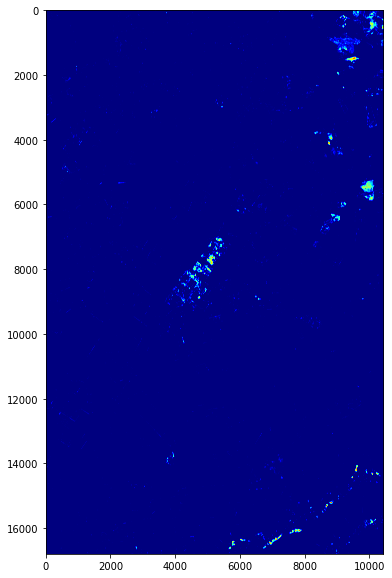

In [155]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.uncertainty_to_show, cmap = 'jet')


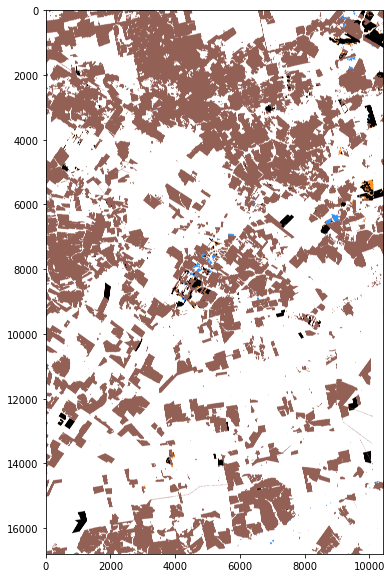

In [156]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.error_mask_to_show_rgb[...,::-1])


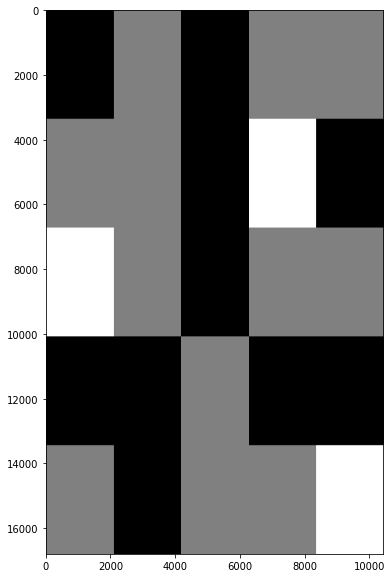

In [157]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.mask_train_val, cmap='gray')

In [158]:
manager.mask_train_val.shape

(16795, 10420)

In [159]:
manager.dataset.previewLims0 = np.array([3850, 4150, 11800, 12100])
manager.dataset.previewLims1 = np.array([3500, 4500, 14000, 15000])
manager.dataset.previewLims2 = np.array([13600, 13900, 4450, 4750])
manager.dataset.previewLims3 = np.array([17770, 18070, 14600, 14900])
manager.dataset.previewLims4 = np.array([ 6000,  7000, 15600, 16600])


manager.dataset.previewLims0 = np.array([2600, 3300, 13450, 14150])
manager.dataset.previewLims1 = np.array([1300, 2000, 11000, 11700])
manager.dataset.previewLims2 = np.array([6300, 7300, 12200, 13200])    

manager.dataset.previewLims3 = np.array([4300, 5300, 2600, 3600])  
manager.dataset.previewLims4 = np.array([18355, 19355, 10600, 11600]) 
manager.dataset.previewLims5 = np.array([6000, 6500, 14800, 15300])   

In [160]:
'''
if config['site'] == 'PI':
    manager.dataset.previewLims1 = np.array([2000, 3000, 1500, 2500])
    # manager.dataset.previewLims2 = np.array([6300, 7300, 10000, 11000])
    manager.dataset.previewLims2 = np.array([2200, 3200, 9000, 10000])
elif config['site'] == 'MS':
    manager.dataset.previewLims1 = np.array([13250, 14250, 4000, 5000])
    # manager.dataset.previewLims2 = np.array([6300, 7300, 10000, 11000])
    manager.dataset.previewLims2 = np.array([13500, 14500, 16250, 17250])
'''

"\nif config['site'] == 'PI':\n    manager.dataset.previewLims1 = np.array([2000, 3000, 1500, 2500])\n    # manager.dataset.previewLims2 = np.array([6300, 7300, 10000, 11000])\n    manager.dataset.previewLims2 = np.array([2200, 3200, 9000, 10000])\nelif config['site'] == 'MS':\n    manager.dataset.previewLims1 = np.array([13250, 14250, 4000, 5000])\n    # manager.dataset.previewLims2 = np.array([6300, 7300, 10000, 11000])\n    manager.dataset.previewLims2 = np.array([13500, 14500, 16250, 17250])\n"

In [161]:
# manager.config['uncertainty_method'] = 'MI'

In [162]:

if config['site'] == 'MS':
    # previewLims0 = np.array([6000, 7000, 15600, 16600])
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='0')
    # previewLims3 = np.array([2200, 3200, 16300, 17300])
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, save_name='3')
    # previewLims4 = np.array([12500, 13500, 7000, 8000])    
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims4, save_name='4')

elif config['site'] == 'PI':

    manager.dataset.previewLims1 = np.array([18355, 19355, 10600, 11600])
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims0, save_name='0')
    # previewLims3 = np.array([2200, 3200, 16300, 17300])
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')
    # previewLims4 = np.array([12500, 13500, 7000, 8000])    
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, save_name='2')
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims3, save_name='3')
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims4, save_name='4')



In [163]:

if config['site'] == 'MS':
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims0, save_name='0')
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')
    manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, save_name='2')
    # manager.logger.plotCropSampleT0T1(manager, previewLims0, save_name='5')
    manager.logger.plotCropSampleT0T1(manager, previewLims3, save_name='3')
    manager.logger.plotCropSampleT0T1(manager, previewLims4, save_name='4')

elif config['site'] == 'PI':

    manager.dataset.previewLims1 = np.array([18355, 19355, 10600, 11600])



In [164]:
import gc
gc.collect()

40906

In [165]:
if config['site'] == 'PI':

    manager.dataset.previewLims2 = np.array([100, 1100, 7700, 8700])


In [166]:
if config['site'] == 'PI':
    previewLims0 = np.array([6000, 7000, 14500, 15500])    

    manager.logger.plotCropSampleT0T1(manager, previewLims0, save_name='0')


In [167]:
if config['site'] == 'PI':
    previewLims3 = np.array([12000, 13000, 13000, 14000])    

    manager.logger.plotCropSampleT0T1(manager, previewLims3, save_name='3')


In [168]:
if config['site'] == 'PI':
    previewLims4 = np.array([4300, 5300, 2600, 3600])    

    manager.logger.plotCropSampleT0T1(manager, previewLims4, save_name='4')


In [169]:
'''
manager.dataset.previewLims1 = np.array([2500, 5000, 15000, 17500])
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='0')
manager.dataset.previewLims1 = np.array([12500, 15000, 2500, 5000])
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')
manager.dataset.previewLims1 = np.array([15000, 17500, 2000, 3000])
manager.dataset.previewLims1 = np.array([5000, 7500, 15000, 17500])

manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='2')
'''


# manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')
# manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, save_name='2')

# manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, colorbar=True, save_name='Colorbar')

"\nmanager.dataset.previewLims1 = np.array([2500, 5000, 15000, 17500])\nmanager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='0')\nmanager.dataset.previewLims1 = np.array([12500, 15000, 2500, 5000])\nmanager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')\nmanager.dataset.previewLims1 = np.array([15000, 17500, 2000, 3000])\nmanager.dataset.previewLims1 = np.array([5000, 7500, 15000, 17500])\n\nmanager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='2')\n"

In [170]:
manager.logger.getStats(manager.uncertainty)


ic| Logger.py:123 in getStats()
    np.min(value): 5.9095873e-25
    np.mean(value): 0.0012910764
    np.max(value): 0.2162962


In [171]:
'''
manager.getOtherUncertaintyMetrics()
print(manager.sUEO)

print(manager.ece_score)  
'''

'\nmanager.getOtherUncertaintyMetrics()\nprint(manager.sUEO)\n\nprint(manager.ece_score)  \n'

In [172]:
if config["plotPOI"] == True and config['site'] == 'PA':

    print(manager.mean_prob.shape)
    font = {'family': "Times New Roman",
            'color':  'white',
            'weight': 'bold',
            'size': 24,
            }

    lims = dataset.previewLims1
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['A', 'B', 'C', 'D', 'E', 'F']

    for poi_id in range(4):
            
            plt.text(manager.dataset.snippet_coords['snippet_id0'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id0'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')

    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi0.png'), 
    dpi=150, bbox_inches='tight')

    lims = dataset.previewLims2
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['E', 'F']

    print(manager.dataset.snippet_coords['snippet_id1'])
    for poi_id in range(2):
            
            plt.text(manager.dataset.snippet_coords['snippet_id1'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id1'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')
            
    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi1.png'), 
    dpi=150, bbox_inches='tight')

In [173]:
if config["plotPOI"] == True and config['site'] == 'PA':
    manager.getPOIValues()


In [174]:

if config["plotPOI"] == True and config['site'] == 'PA':
    import pickle
    with open('output/log/log_ensemble_.pkl', 'wb') as f:
                pickle.dump(manager.snippet_poi_results, f)


In [175]:
'''
print(manager.uncertainty.shape)
print(manager.label_mask_current_deforestation_test.shape)
print(manager.predicted_test.shape)
'''

'\nprint(manager.uncertainty.shape)\nprint(manager.label_mask_current_deforestation_test.shape)\nprint(manager.predicted_test.shape)\n'

In [176]:
# error_test = np.abs(manager.label_mask_current_deforestation_test - manager.predicted_test)

In [177]:
# np.unique(error_test, return_counts=True)

In [178]:
'''
error_test_str = np.array(error_test, dtype=np.str)
error_test_str[error_test == 0] = 'Correct'
error_test_str[error_test == 1] = 'Error'
'''

"\nerror_test_str = np.array(error_test, dtype=np.str)\nerror_test_str[error_test == 0] = 'Correct'\nerror_test_str[error_test == 1] = 'Error'\n"

In [179]:
'''
import seaborn as sns
penguins = sns.load_dataset("penguins")

sns.displot(penguins, x="flipper_length_mm", hue="species", kind="kde", fill=True)
'''

'\nimport seaborn as sns\npenguins = sns.load_dataset("penguins")\n\nsns.displot(penguins, x="flipper_length_mm", hue="species", kind="kde", fill=True)\n'

In [180]:
'''
import pandas as pd
df = pd.DataFrame({'uncertainty': manager.uncertainty.flatten(), 
                    'label': manager.label_mask_current_deforestation_test.flatten(),
                    'error_test': error_test_str.flatten()})
'''

"\nimport pandas as pd\ndf = pd.DataFrame({'uncertainty': manager.uncertainty.flatten(), \n                    'label': manager.label_mask_current_deforestation_test.flatten(),\n                    'error_test': error_test_str.flatten()})\n"

In [181]:
# df

In [182]:
# np.max(df['uncertainty'])

In [183]:
# g = sns.histplot(df.sample(1000), x="uncertainty", hue="error_test", kind='hist', stat='density')


In [184]:
manager.config['uncertainty_method']

'pred_var'

In [262]:
from src import metrics as _metrics

def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy_single":
        self.threshold_list = [0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    if self.config['uncertainty_method'] == "pred_entropy":
            if self.classes_mode == False:
                # self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                #            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                        0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]                            
                    # self.threshold_list = [0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 
                    #         0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            else:
                    self.threshold_list = [0.0025, 0.025, 0.05, 0.075, 0.1, 0.2, 0.4, 
                    0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                    
                    # self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    # 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
            self.threshold_list = np.linspace(np.min(self.uncertainty) + 0.000015, np.max(self.uncertainty) - 0.0015, 19)
            self.threshold_list = [0.1e-07, 0.1e-06, 0.1e-05, 1.5e-05, 8e-05, 1.5e-04, 1.5e-03] + \
                list(np.linspace(np.min(self.uncertainty) + 0.000015, np.max(self.uncertainty) - 0.0015, 19))
            self.threshold_list.insert(3, self.threshold_list.pop(7))

            # self.threshold_list = np.linspace(np.min(self.uncertainty) + 0.00000015, np.max(self.uncertainty) - 0.0015, 19)
            # self.threshold_list = np.logspace(np.min(self.uncertainty) + 0.00000015, np.max(self.uncertainty) - 0.0015, 19)

    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            self.threshold_list = [0.00001, 0.0005, 0.0001] + [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5],
            'UEO': metrics_values[:,6]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [263]:
manager.threshold_list

[1e-06,
 0.00015,
 1.5e-05,
 8e-05,
 0.0015,
 1.5e-05,
 0.011947288665771485,
 0.023879577331542973,
 0.03581186599731446,
 0.047744154663085944,
 0.05967644332885743,
 0.07160873199462892,
 0.08354102066040041,
 0.09547330932617189,
 0.10740559799194337,
 0.11933788665771486,
 0.13127017532348634,
 0.14320246398925782,
 0.1551347526550293,
 0.1670670413208008,
 0.17899932998657228,
 0.19093161865234376,
 0.20286390731811524,
 0.21479619598388672]

In [270]:
manager.threshold_list

[1e-07,
 1e-06,
 8e-05,
 1.5e-05,
 0.00015,
 0.0015,
 1.5e-05,
 0.011947288665771485,
 0.023879577331542973,
 0.03581186599731446,
 0.047744154663085944,
 0.05967644332885743,
 0.07160873199462892,
 0.08354102066040041,
 0.09547330932617189,
 0.10740559799194337,
 0.11933788665771486,
 0.13127017532348634,
 0.14320246398925782,
 0.1551347526550293,
 0.1670670413208008,
 0.17899932998657228,
 0.19093161865234376,
 0.20286390731811524,
 0.21479619598388672]

In [265]:
manager.config['uncertainty_method']

'pred_var'

In [266]:
# manager.threshold_list

In [267]:


# manager.threshold_list.insert(0, manager.threshold_list.pop(3))

In [268]:

import types

manager.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, manager)



Get precision-recall threshold

In [269]:

manager.getUncertaintyAAValues()

ic| 2401082105.py:73 in getUncertaintyAAValues()
    self.uncertainty.shape: (44623406,)
    self.label_mask_current_deforestation_test.shape: (44623406,)


[1e-07, 1e-06, 8e-05, 1.5e-05, 0.00015, 0.0015, 1.5e-05, 0.011947288665771485, 0.023879577331542973, 0.03581186599731446, 0.047744154663085944, 0.05967644332885743, 0.07160873199462892, 0.08354102066040041, 0.09547330932617189, 0.10740559799194337, 0.11933788665771486, 0.13127017532348634, 0.14320246398925782, 0.1551347526550293, 0.1670670413208008, 0.17899932998657228, 0.19093161865234376, 0.20286390731811524, 0.21479619598388672]
threshold 1e-07


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (4619934,)
    predicted_test_high_uncertainty.shape: (4619934,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 4619934
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 4619934
    len(label_mask_current_deforestation_test): 44623406


[0.98883644 0.99271051 0.25529186 0.10353163 0.75525348 0.74890306
 0.06833928]
threshold 1e-06


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (3706776,)
    predicted_test_high_uncertainty.shape: (3706776,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3706776
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3706776
    len(label_mask_current_deforestation_test): 44623406


[0.98725461 0.98895508 0.28924496 0.08306798 0.74432925 0.73828832
 0.08460004]
threshold 8e-05


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (2256604,)
    predicted_test_high_uncertainty.shape: (2256604,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2256604
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2256604
    len(label_mask_current_deforestation_test): 44623406


[0.98180556 0.96775297 0.3610977  0.05056996 0.71853987 0.71865695
 0.13374635]
threshold 1.5e-05


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (2765279,)
    predicted_test_high_uncertainty.shape: (2765279,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2765279
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2765279
    len(label_mask_current_deforestation_test): 44623406


[0.98490966 0.97640651 0.33212886 0.06196925 0.72918822 0.72664456
 0.11121716]
threshold 0.00015


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (2081148,)
    predicted_test_high_uncertainty.shape: (2081148,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2081148
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2081148
    len(label_mask_current_deforestation_test): 44623406


[0.97932997 0.96469921 0.37341906 0.04663804 0.71428031 0.71491473
 0.14360983]
threshold 0.0015


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1484295,)
    predicted_test_high_uncertainty.shape: (1484295,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1484295
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1484295
    len(label_mask_current_deforestation_test): 44623406


[0.96999518 0.95299536 0.43235962 0.0332627  0.69075295 0.69418281
 0.19165837]
threshold 1.5e-05


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (2765279,)
    predicted_test_high_uncertainty.shape: (2765279,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2765279
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2765279
    len(label_mask_current_deforestation_test): 44623406


[0.98490966 0.97640651 0.33212886 0.06196925 0.72918822 0.72664456
 0.11121716]
threshold 0.011947288665771485


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (898632,)
    predicted_test_high_uncertainty.shape: (898632,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 898632
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 898632
    len(label_mask_current_deforestation_test): 44623406


KeyboardInterrupt: 

In [ ]:
manager.getUncertaintyAAAuditedValues()

ic| base.py:736 in getUncertaintyAAAuditedValues()
    self.uncertainty.shape: (44623406,)
    self.label_mask_current_deforestation_test.shape: (44623406,)


threshold 1e-06
(44623406,) (44623406,)
cm_audited [[43758677     3217]
 [    2783   858729]]
[0.99626775 0.99676963]
threshold 0.00015
(44623406,) (44623406,)
cm_audited [[43755104     6790]
 [   11772   849740]]
[0.99207267 0.98633565]
threshold 1.5e-05
(44623406,) (44623406,)
cm_audited [[43757510     4384]
 [    6914   854598]]
[0.99489628 0.99197457]
threshold 8e-05
(44623406,) (44623406,)


KeyboardInterrupt: 

In [ ]:
manager.setPlotLimsForUncertaintyAA()

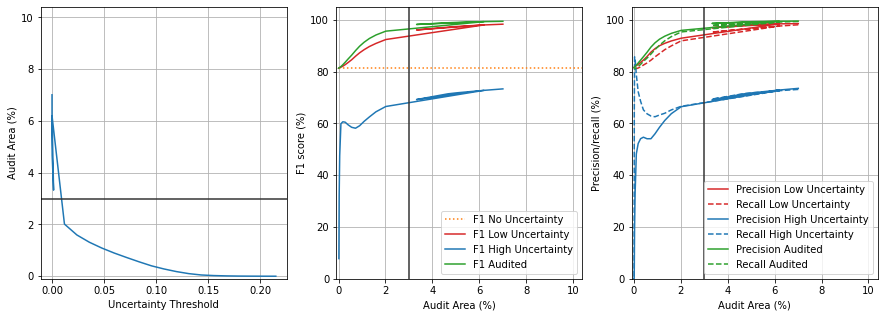

In [ ]:
'''
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]
'''
manager.plotUncertaintyAA(normalize_xlim=False)

In [ ]:
from scipy import optimize  

manager.getOptimalUncertaintyThreshold(bounds=(np.min(manager.uncertainty) + 0.000015, np.max(manager.uncertainty) - 0.0015))

ic| base.py:845 in getOptimalUncertaintyThreshold()
    bounds: (1.5e-05, 0.21479619598388672)


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.0820541167214923
threshold 0.0820541167214923


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (258570,)
    predicted_test_high_uncertainty.shape: (258570,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 258570
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 258570
    len(label_mask_current_deforestation_test): 44623406


[0.86169869 0.83508088 0.73642155 0.00579449 0.53644699 0.63635024
 0.19144104]
0.13275707926239438
threshold 0.13275707926239438


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (40631,)
    predicted_test_high_uncertainty.shape: (40631,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 40631
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 40631
    len(label_mask_current_deforestation_test): 44623406


[0.82267337 0.81179824 0.80263537 0.00091053 0.46900613 0.79442616
 0.03070114]
0.05071796254090209
threshold 0.05071796254090209


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (463552,)
    predicted_test_high_uncertainty.shape: (463552,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 463552
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 463552
    len(label_mask_current_deforestation_test): 44623406


[0.89778692 0.86712748 0.66371217 0.01038809 0.57885818 0.63043177
 0.27160866]
0.03135115418059023
threshold 0.03135115418059023


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (628832,)
    predicted_test_high_uncertainty.shape: (628832,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 628832
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 628832
    len(label_mask_current_deforestation_test): 44623406


[0.91333305 0.89052417 0.6053485  0.01409198 0.62130022 0.64407271
 0.27814302]
0.019381808360311874
threshold 0.019381808360311874


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (769592,)
    predicted_test_high_uncertainty.shape: (769592,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 769592
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 769592
    len(label_mask_current_deforestation_test): 44623406


[0.92255515 0.90669909 0.56170779 0.01724638 0.6475615  0.65676728
 0.26706868]
0.01198434582027836
threshold 0.01198434582027836


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (897731,)
    predicted_test_high_uncertainty.shape: (897731,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 897731
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 897731
    len(label_mask_current_deforestation_test): 44623406


[0.92939936 0.91922166 0.52799613 0.02011794 0.66471692 0.66635939
 0.25258111]
0.007412462540033517
threshold 0.007412462540033517


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1026673,)
    predicted_test_high_uncertainty.shape: (1026673,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1026673
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1026673
    len(label_mask_current_deforestation_test): 44623406


[0.93490696 0.93069127 0.50047591 0.0230075  0.67718594 0.67306403
 0.23693197]
0.004586883280244844
threshold 0.004586883280244844


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1163207,)
    predicted_test_high_uncertainty.shape: (1163207,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1163207
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1163207
    len(label_mask_current_deforestation_test): 44623406


[0.93945984 0.94008393 0.47635785 0.02606719 0.68738948 0.67962058
 0.22001729]
0.0028405792597886743
threshold 0.0028405792597886743


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1303304,)
    predicted_test_high_uncertainty.shape: (1303304,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1303304
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1303304
    len(label_mask_current_deforestation_test): 44623406


[0.94863777 0.94709392 0.45529023 0.02920674 0.69210911 0.68616984
 0.20569096]
0.0017613040204561697
threshold 0.0017613040204561697


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1440206,)
    predicted_test_high_uncertainty.shape: (1440206,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1440206
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1440206
    len(label_mask_current_deforestation_test): 44623406


[0.96675924 0.95175111 0.43758067 0.03227468 0.68990442 0.69232951
 0.19563412]
0.0029125936801035774
threshold 0.0029125936801035774


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1296022,)
    predicted_test_high_uncertainty.shape: (1296022,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1296022
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1296022
    len(label_mask_current_deforestation_test): 44623406


[0.94785953 0.94679117 0.45631402 0.02904355 0.69210228 0.68582946
 0.206296  ]
0.002518091066585862
threshold 0.002518091066585862


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1338498,)
    predicted_test_high_uncertainty.shape: (1338498,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1338498
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1338498
    len(label_mask_current_deforestation_test): 44623406


[0.95321811 0.94833552 0.45043714 0.02999542 0.6915983  0.68790265
 0.20303057]
0.002229024137209954
threshold 0.002229024137209954


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1373662,)
    predicted_test_high_uncertainty.shape: (1373662,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1373662
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1373662
    len(label_mask_current_deforestation_test): 44623406


[0.95843479 0.9495467  0.44593575 0.03078344 0.69060569 0.68945548
 0.20062365]
0.0025514244372685214
threshold 0.0025514244372685214


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1334673,)
    predicted_test_high_uncertainty.shape: (1334673,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1334673
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1334673
    len(label_mask_current_deforestation_test): 44623406


[0.95269424 0.94821144 0.45097805 0.02990971 0.69165865 0.68770102
 0.2033101 ]
0.0024560387087231086
threshold 0.0024560387087231086


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1345741,)
    predicted_test_high_uncertainty.shape: (1345741,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1345741
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1345741
    len(label_mask_current_deforestation_test): 44623406
ic| base.py:849 in getOptimalUncertaintyThreshold()
    self.threshold_optimal: 0.002518091066585862


[0.95428188 0.94862693 0.44948764 0.03015774 0.69140175 0.68820786
 0.20254479]


In [ ]:
manager.getUncertaintyMetricsFromOptimalThreshold()

threshold:  0.002518091066585862
threshold 0.002518091066585862


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_high_uncertainty.shape: (1338498,)
    predicted_test_high_uncertainty.shape: (1338498,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1338498
    len(label_mask_current_deforestation_test): 44623406
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1338498
    len(label_mask_current_deforestation_test): 44623406


[0.95321811 0.94833552 0.45043714 0.02999542 0.6915983  0.68790265
 0.20303057]
threshold 0.002518091066585862
(44623406,) (44623406,)


ic| base.py:880 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_optimal: {'AA': array([0.02999542]),
                     'UEO': array([0.20303057]),
                     'f1': 81.37,
                     'f1_H': array([0.68974553]),
                     'f1_L': array([0.95077055]),
                     'precision_H': array([0.6915983]),
                     'precision_L': array([0.95321811]),
                     'recall_H': array([0.68790265]),
                     'recall_L': array([0.94833552]),
                     'recall_Ltotal': array([0.45043714])}
ic| base.py:881 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_audited_optimal: {'f1': array([0.97664865]),
                             'precision': array([0.9778396]),
                             'recall': array([0.97546059])}


cm_audited [[43742849    19045]
 [   21141   840371]]
[0.9778396  0.97546059]


{'metrics': {'precision_L': array([0.95321811]),
  'recall_L': array([0.94833552]),
  'recall_Ltotal': array([0.45043714]),
  'AA': array([0.02999542]),
  'precision_H': array([0.6915983]),
  'recall_H': array([0.68790265]),
  'UEO': array([0.20303057]),
  'f1_L': array([0.95077055]),
  'f1_H': array([0.68974553]),
  'f1': 81.37},
 'metrics_audited': {'precision': array([0.9778396]),
  'recall': array([0.97546059]),
  'f1': array([0.97664865])},
 'exp': 2}

In [ ]:
manager.threshold_optimal

0.002518091066585862

In [ ]:
manager.dataset.paths.im_filenames[dates[1]][0]
manager.dataset.paths.optical_im_past_dates[dates[1]]

'D:/Jorge/datasets/sentinel2/MT/2020'

In [ ]:
if config['georreferenced_save'] == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_uncertainty_georreferenced.tif'.format(
        manager.dataset.site)
    print("manager.uncertainty_to_show.shape", manager.uncertainty_to_show.shape)
    save_georreferenced(manager.uncertainty_to_show, original_im_path,produced_im_path)


In [ ]:
manager.predicted_unpad.shape

(16795, 10420)

In [ ]:

if config['georreferenced_save'] == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_uncertainty_georreferenced_jet.tif'.format(
        manager.dataset.site)

    jet_colormap_image = plt.get_cmap('jet')(manager.uncertainty_to_show)[..., :-1]
    jet_colormap_image = (jet_colormap_image * 255).astype('uint8')
    save_georreferenced(jet_colormap_image, original_im_path,produced_im_path, bands = 3)


In [ ]:
if config['georreferenced_save'] == True:
    del jet_colormap_image

In [ ]:
if config['georreferenced_save'] == True:
    # jet_colormap_image.shape
    jet_colormap_image = plt.get_cmap('jet')(manager.uncertainty_to_show)
    jet_colormap_image = (jet_colormap_image * 255).astype('uint8')

In [ ]:
if config['georreferenced_save'] == True:
    print(np.min(jet_colormap_image), np.max(jet_colormap_image))

In [ ]:
if config['georreferenced_save'] == True:
    plt.imshow(jet_colormap_image[...,:-1])

In [ ]:
if config['georreferenced_save'] == True:
    predicted_to_show = manager.predicted_unpad.copy()
    predicted_to_show[manager.label_mask == 2] = 0 # 1 for deforestation. 0 for the rest

    false_positive_mask = predicted_to_show - manager.label_mask_current_deforestation # 0 for correct. 1 for false positive. -1 for false negative
    false_positive_mask = (false_positive_mask + 1).astype(np.int8) # 1 for correct. 2 for false positive. 0 for false negative
    del predicted_to_show
    ic(np.unique(false_positive_mask, return_counts=True))

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_false_positive_mask_georreferenced.tif'.format(
        manager.dataset.site)
    print("false_positive_mask.shape", false_positive_mask.shape)
    save_georreferenced(false_positive_mask, original_im_path,produced_im_path)

    # del false_positive_mask


In [ ]:
if config['georreferenced_save'] == True:
    predicted_georreferenced = manager.predicted_unpad.copy()
    predicted_georreferenced[manager.label_mask == 2] = 2 

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_predicted_georreferenced.tif'.format(
        manager.dataset.site)
    print("predicted_georreferenced.shape", predicted_georreferenced.shape)
    save_georreferenced(predicted_georreferenced, original_im_path,produced_im_path)
    del predicted_georreferenced



In [ ]:

if config['georreferenced_save'] == True:
    visual_roi_mask = np.zeros_like(false_positive_mask)

    if config['site'] == 'MS':
        lims = manager.dataset.previewLims0
        visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1
        lims = manager.dataset.previewLims3
        visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1
        lims = manager.dataset.previewLims4
        visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

    if config['site'] == 'PI':
        lims = manager.dataset.previewLims0
        visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

        lims = manager.dataset.previewLims3
        visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

        lims = manager.dataset.previewLims4
        visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

    lims = manager.dataset.previewLims1
    visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

    lims = manager.dataset.previewLims2
    visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

    print(visual_roi_mask.shape)
    # visual_roi_mask_pad = rasterTools.padForGeorreferencingPA(visual_roi_mask)


    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(visual_roi_mask, cmap='jet')
    plt.axis('off')

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_visual_roi_georreferenced.tif'.format(
        manager.dataset.site
    )
    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(visual_roi_mask, axis=0).astype(np.float32), produced_im_path, bands = 1,
                    nodata=-1)

In [ ]:
# print(previewLims0)

# print(previewLims3)

# print(previewLims4)

print(manager.dataset.previewLims1)

print(manager.dataset.previewLims2)

[ 1300  2000 11000 11700]
[ 6300  7300 12200 13200]
